In [1]:
from EnsembleFramework import Framework

In [2]:
from torch_geometric.datasets import PPI
import torch_geometric.transforms as T
from torch_geometric.utils import add_self_loops
from torch_geometric.loader import DataLoader

train_dataset = PPI(root='/tmp/PPI', split="train")
val_dataset = PPI(root='/tmp/PPI', split="val")
test_dataset = PPI(root='/tmp/PPI', split="test")
train_dataset.transform = T.NormalizeFeatures()
val_dataset.transform = T.NormalizeFeatures()
test_dataset.transform = T.NormalizeFeatures()

train_loader = iter(DataLoader(train_dataset, batch_size=len(train_dataset)))
val_loader = iter(DataLoader(val_dataset, batch_size=len(val_dataset)))
test_loader = iter(DataLoader(test_dataset, batch_size=len(test_dataset)))

In [3]:
train_set = next(train_loader)
test_set = next(test_loader)
val_set = next(val_loader)

In [4]:
import torch

train_size = train_set.y.shape[0]
test_size = test_set.y.shape[0]
val_size = val_set.y.shape[0]
mask = torch.zeros(train_size + test_size + val_size)
train_mask = torch.clone(mask)
train_mask[:train_size] = 1
train_mask = train_mask.type(torch.bool)

test_mask = torch.clone(mask)
test_mask[train_size:train_size+test_size] = 1
test_mask = test_mask.type(torch.bool)

val_mask = torch.clone(mask)
val_mask[train_size+test_size:] = 1
val_mask = val_mask.type(torch.bool)

In [5]:
complete_set = next(iter(DataLoader([train_set, test_set, val_set], batch_size=train_size+test_size+val_size)))

In [6]:
complete_data = {"X": complete_set.x,
                 "y": complete_set.y,
                "edge_index": complete_set.edge_index, "test": test_mask, "train": train_mask, "val": val_mask}

In [7]:
from hyperopt import fmin, tpe, hp
from xgboost import XGBClassifier
clfs = [XGBClassifier]

booster_self = ["gbtree"]
n_estimators_self = [5, 50, 100,150, 200, 400, 500, 800, 1_000, 1_200]
max_depth_self = [None, 1, 2, 3, 4]
max_delta_step_self = [None, 1, 2, 3, 4]
min_child_weight_self = [None, 1, 2, 3, 4]

xb_choices = {
    'booster': booster_self,
    'n_estimators': n_estimators_self,
    'max_depth': max_depth_self,
    'max_delta_step': max_delta_step_self,
    'min_child_weight': min_child_weight_self,
}
space_xb = {
    **{key: hp.choice(key, value) for key, value in xb_choices.items()},
    'eta': hp.loguniform('eta', -3, -.3),
    'subsample': hp.uniform('subsample', 0.6, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'alpha': hp.uniform('alpha', 0, 1),
}
clfs_space = dict({})
clfs_space["XGBClassifier"] = space_xb

In [9]:
from AutoTune import AutoSearch
from sklearn.metrics import f1_score

searcher = AutoSearch(complete_data, multi_target_class=True, max_evals=10, pred_metric = f1_score, pred_metric_kwargs={"average":"micro"})
store = searcher.search(clfs, clfs_space, hops=[5])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Because the requested parallelism was None or a non-positive value, parallelism will be set to (64), which is Spark's default parallelism (64), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.





  0%|                                                                            | 0/10 [00:00<?, ?trial/s, best loss=?]

Multi class                 (0 + 1) / 1][Stage 81:>                 (0 + 1) / 1]
Multi class   (0 + 1) / 1][Stage 81:>   (0 + 1) / 1][Stage 82:>   (0 + 1) / 1]
Multi class
Multi class
Multi class
Multi class
Multi class
Multi class
Multi class
Multi class
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(





 10%|████▊                                           | 1/10 [00:24<03:36, 24.10s/trial, best loss: -0.41048695458284495]




 20%|█████████▊                                       | 2/10 [00:28<01:38, 12.28s/trial, best loss: -0.4345113172541744]

/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(





 30%|██████████████▋                                  | 3/10 [00:41<01:28, 12.62s/trial, best loss: -0.4345113172541744]

/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:3




 40%|███████████████████▌                             | 4/10 [01:06<01:45, 17.52s/trial, best loss: -0.6158198516510774]

/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(





 50%|████████████████████████▌                        | 5/10 [01:17<01:15, 15.17s/trial, best loss: -0.6158198516510774]




 60%|█████████████████████████████▍                   | 6/10 [01:34<01:03, 15.80s/trial, best loss: -0.6158198516510774]

/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(





 70%|██████████████████████████████████▎              | 7/10 [02:04<01:01, 20.46s/trial, best loss: -0.6322533318211543]




 80%|███████████████████████████████████████▏         | 8/10 [02:06<00:29, 14.58s/trial, best loss: -0.6322533318211543]

/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(





 90%|████████████████████████████████████████████     | 9/10 [03:29<00:36, 36.00s/trial, best loss: -0.6378881092981626]




100%|████████████████████████████████████████████████| 10/10 [04:13<00:00, 25.34s/trial, best loss: -0.6562224420094617]


Total Trials: 10: 10 succeeded, 0 failed, 0 cancelled.
INFO:hyperopt-spark:Total Trials: 10: 10 succeeded, 0 failed, 0 cancelled.


Multi class


/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
Because the requested parallelism was None or a non-positive value, parallelism will be set to (64), whi




  0%|                                                                            | 0/10 [00:00<?, ?trial/s, best loss=?]

Multi class                 (0 + 1) / 1][Stage 91:>                 (0 + 1) / 1]
Multi class   (0 + 1) / 1][Stage 91:>   (0 + 1) / 1][Stage 92:>   (0 + 1) / 1]
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
Multi class
Multi class
Multi class
Multi class
Multi class
Multi class
Multi class
Multi class
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/l




 10%|████▉                                            | 1/10 [01:00<09:01, 60.12s/trial, best loss: -0.4700447256463401]

/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(





 20%|█████████▊                                       | 2/10 [01:15<04:28, 33.59s/trial, best loss: -0.4706888894338317]




 30%|██████████████▋                                  | 3/10 [01:23<02:33, 21.91s/trial, best loss: -0.4706888894338317]

/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(





 40%|███████████████████▌                             | 4/10 [02:01<02:49, 28.28s/trial, best loss: -0.4706888894338317]

/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(





 50%|████████████████████████▌                        | 5/10 [03:31<04:12, 50.57s/trial, best loss: -0.4734905805948613]

/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(





 60%|█████████████████████████████▍                   | 6/10 [03:43<02:29, 37.46s/trial, best loss: -0.4734905805948613]




 70%|██████████████████████████████████▎              | 7/10 [04:06<01:38, 32.74s/trial, best loss: -0.4734905805948613]




 80%|███████████████████████████████████████▏         | 8/10 [04:29<00:59, 29.65s/trial, best loss: -0.4734905805948613]




 90%|████████████████████████████████████████████     | 9/10 [04:41<00:24, 24.14s/trial, best loss: -0.4734905805948613]




100%|████████████████████████████████████████████████| 10/10 [04:47<00:00, 28.74s/trial, best loss: -0.4734905805948613]


Total Trials: 10: 10 succeeded, 0 failed, 0 cancelled.
INFO:hyperopt-spark:Total Trials: 10: 10 succeeded, 0 failed, 0 cancelled.


Multi class


Because the requested parallelism was None or a non-positive value, parallelism will be set to (64), which is Spark's default parallelism (64), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.





  0%|                                                                            | 0/10 [00:00<?, ?trial/s, best loss=?]

Multi class>                (0 + 1) / 1][Stage 101:>                (0 + 1) / 1]
Multi class>  (0 + 1) / 1][Stage 101:>  (0 + 1) / 1][Stage 102:>  (0 + 1) / 1]
Multi class
Multi class
Multi class
Multi class
Multi class
Multi class
Multi class
Multi class





 10%|████▉                                            | 1/10 [00:21<03:09, 21.08s/trial, best loss: -0.4105670041118618]




 20%|█████████▊                                       | 2/10 [00:46<03:07, 23.40s/trial, best loss: -0.4526452558054362]




 30%|██████████████▋                                  | 3/10 [00:52<01:48, 15.46s/trial, best loss: -0.5774035007932857]

/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:3




 40%|███████████████████▌                             | 4/10 [02:09<03:58, 39.79s/trial, best loss: -0.9089221539434186]




 50%|████████████████████████▌                        | 5/10 [02:27<02:39, 31.94s/trial, best loss: -0.9089221539434186]




 60%|█████████████████████████████▍                   | 6/10 [02:28<01:25, 21.42s/trial, best loss: -0.9089221539434186]




 70%|██████████████████████████████████▎              | 7/10 [03:16<01:30, 30.13s/trial, best loss: -0.9089221539434186]




 80%|███████████████████████████████████████▏         | 8/10 [03:18<00:42, 21.18s/trial, best loss: -0.9089221539434186]




 90%|████████████████████████████████████████████     | 9/10 [03:33<00:19, 19.25s/trial, best loss: -0.9089221539434186]

/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:3




100%|████████████████████████████████████████████████| 10/10 [04:50<00:00, 29.04s/trial, best loss: -0.9597256576976154]


Total Trials: 10: 10 succeeded, 0 failed, 0 cancelled.
INFO:hyperopt-spark:Total Trials: 10: 10 succeeded, 0 failed, 0 cancelled.


Multi class


/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:3




  0%|                                                                            | 0/10 [00:00<?, ?trial/s, best loss=?]

Multi class>                (0 + 1) / 1][Stage 111:>                (0 + 1) / 1]
Multi class>  (0 + 1) / 1][Stage 111:>  (0 + 1) / 1][Stage 112:>  (0 + 1) / 1]
Multi class
Multi class
Multi class
Multi class
Multi class
Multi class
Multi class
Multi class





 10%|████▊                                           | 1/10 [00:33<04:57, 33.09s/trial, best loss: -0.40817633623762856]




 20%|█████████▊                                       | 2/10 [00:49<03:04, 23.05s/trial, best loss: -0.4553291039314998]

/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(





 30%|██████████████▍                                 | 3/10 [01:00<02:02, 17.55s/trial, best loss: -0.46620515832511245]




 40%|███████████████████▏                            | 4/10 [01:05<01:15, 12.60s/trial, best loss: -0.46620515832511245]

/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(





 50%|████████████████████████                        | 5/10 [01:17<01:01, 12.39s/trial, best loss: -0.47581194961258955]




 60%|█████████████████████████████▍                   | 6/10 [01:24<00:42, 10.56s/trial, best loss: -0.5212157394843963]


 70%|██████████████████████████████████▎              | 7/10 [01:42<00:39, 13.00s/trial, best loss: -0.5212157394843963]




 80%|███████████████████████████████████████▏         | 8/10 [01:54<00:25, 12.69s/trial, best loss: -0.5277818984094961]

/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(





 90%|████████████████████████████████████████████     | 9/10 [02:02<00:11, 11.23s/trial, best loss: -0.6399783553098406]

/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(





100%|█████████████████████████████████████████████████| 10/10 [02:18<00:00, 13.83s/trial, best loss: -0.703859386686612]

Total Trials: 10: 10 succeeded, 0 failed, 0 cancelled.
INFO:hyperopt-spark:Total Trials: 10: 10 succeeded, 0 failed, 0 cancelled.


Multi class


Because the requested parallelism was None or a non-positive value, parallelism will be set to (64), which is Spark's default parallelism (64), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.





  0%|                                                                            | 0/10 [00:00<?, ?trial/s, best loss=?]

Multi class>                (0 + 1) / 1][Stage 121:>                (0 + 1) / 1]
Multi class>  (0 + 1) / 1][Stage 121:>  (0 + 1) / 1][Stage 122:>  (0 + 1) / 1]
Multi class
Multi class
Multi class
Multi class
Multi class
Multi class
Multi class
Multi class
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(





 10%|████▊                                           | 1/10 [00:32<04:48, 32.10s/trial, best loss: -0.39921787169227424]




 20%|█████████▌                                      | 2/10 [00:34<01:55, 14.40s/trial, best loss: -0.40145655085860477]




 30%|██████████████▋                                  | 3/10 [00:39<01:10, 10.11s/trial, best loss: -0.5344284950793299]




 40%|███████████████████▌                             | 4/10 [00:46<00:53,  8.89s/trial, best loss: -0.5344284950793299]




 50%|████████████████████████▌                        | 5/10 [01:06<01:04, 12.90s/trial, best loss: -0.5344284950793299]




 60%|█████████████████████████████▍                   | 6/10 [02:34<02:33, 38.47s/trial, best loss: -0.5362957766315627]


 70%|██████████████████████████████████▎              | 7/10 [02:46<01:29, 29.82s/trial, best loss: -0.5362957766315627]

/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(





 80%|███████████████████████████████████████▏         | 8/10 [03:10<00:55, 27.98s/trial, best loss: -0.9210243234593365]

/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(





 90%|████████████████████████████████████████████     | 9/10 [03:27<00:24, 24.55s/trial, best loss: -0.9696697751245333]

/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:3




100%|████████████████████████████████████████████████| 10/10 [04:22<00:00, 26.24s/trial, best loss: -0.9708489166635808]


Total Trials: 10: 10 succeeded, 0 failed, 0 cancelled.
INFO:hyperopt-spark:Total Trials: 10: 10 succeeded, 0 failed, 0 cancelled.


Multi class


/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
Because the requested parallelism was None or a non-positive value, parallelism will be set to (64), which is Spark's default parallelism (64), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.





  0%|                                                                            | 0/10 [00:00<?, ?trial/s, best loss=?]

Multi class>                (0 + 1) / 1][Stage 131:>                (0 + 1) / 1]
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
Multi class>  (0 + 1) / 1][Stage 131:>  (0 + 1) / 1][Stage 132:>  (0 + 1) / 1]
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked 




 10%|████▉                                            | 1/10 [00:43<06:28, 43.11s/trial, best loss: -0.4582997013767473]




 20%|█████████▊                                       | 2/10 [01:01<03:46, 28.35s/trial, best loss: -0.5044995222594255]




 30%|██████████████▋                                  | 3/10 [01:02<01:51, 15.87s/trial, best loss: -0.5044995222594255]




 40%|████████████████████                              | 4/10 [01:14<01:26, 14.35s/trial, best loss: -0.556122394125426]




 50%|████████████████████████▌                        | 5/10 [01:27<01:09, 13.87s/trial, best loss: -0.9442091744327724]




 60%|█████████████████████████████▍                   | 6/10 [01:30<00:40, 10.17s/trial, best loss: -0.9442091744327724]




 70%|██████████████████████████████████▎              | 7/10 [01:37<00:27,  9.14s/trial, best loss: -0.9442091744327724]

/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(





 80%|███████████████████████████████████████▏         | 8/10 [02:08<00:32, 16.11s/trial, best loss: -0.9442091744327724]


 90%|████████████████████████████████████████████     | 9/10 [02:18<00:14, 14.21s/trial, best loss: -0.9442091744327724]

/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(





100%|████████████████████████████████████████████████| 10/10 [02:29<00:00, 14.93s/trial, best loss: -0.9442091744327724]

Total Trials: 10: 10 succeeded, 0 failed, 0 cancelled.
INFO:hyperopt-spark:Total Trials: 10: 10 succeeded, 0 failed, 0 cancelled.


Multi class


/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
Because the requested parallelism was None or a non-positive value, parallelism will be set to (64), which is Spark's default parallelism (64), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.





  0%|                                                                            | 0/10 [00:00<?, ?trial/s, best loss=?]

Multi class>                (0 + 1) / 1][Stage 141:>                (0 + 1) / 1]
Multi class>  (0 + 1) / 1][Stage 141:>  (0 + 1) / 1][Stage 142:>  (0 + 1) / 1]
Multi class
Multi class
Multi class
Multi class
Multi class
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
Multi class
Multi class
Multi class





 10%|████▉                                            | 1/10 [00:53<07:58, 53.12s/trial, best loss: -0.4179173785951146]




 20%|█████████▊                                       | 2/10 [00:55<03:04, 23.05s/trial, best loss: -0.5265509177550299]




 30%|██████████████▋                                  | 3/10 [01:00<01:43, 14.81s/trial, best loss: -0.5265509177550299]

/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(





 40%|████████████████████▍                              | 4/10 [01:16<01:31, 15.29s/trial, best loss: -0.68973938046781]




 50%|█████████████████████████▌                         | 5/10 [01:32<01:17, 15.55s/trial, best loss: -0.68973938046781]




 60%|█████████████████████████████▍                   | 6/10 [02:02<01:21, 20.48s/trial, best loss: -0.9645281970110495]




 70%|██████████████████████████████████▎              | 7/10 [02:03<00:42, 14.11s/trial, best loss: -0.9645281970110495]




 80%|███████████████████████████████████████▏         | 8/10 [02:40<00:42, 21.41s/trial, best loss: -0.9727738907479032]




 90%|████████████████████████████████████████████     | 9/10 [02:42<00:15, 15.34s/trial, best loss: -0.9727738907479032]




100%|████████████████████████████████████████████████| 10/10 [03:24<00:00, 20.43s/trial, best loss: -0.9727738907479032]


Total Trials: 10: 10 succeeded, 0 failed, 0 cancelled.
INFO:hyperopt-spark:Total Trials: 10: 10 succeeded, 0 failed, 0 cancelled.


Multi class


/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:3




  0%|                                                                            | 0/10 [00:00<?, ?trial/s, best loss=?]

Multi class>  (0 + 1) / 1][Stage 151:>  (0 + 1) / 1][Stage 152:>  (0 + 1) / 1]1]
Multi class
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
Multi class
Multi class
Multi class
Multi class
Multi class
Multi class
Multi class
Multi class





 10%|████▊                                           | 1/10 [00:37<05:33, 37.10s/trial, best loss: -0.40790388243471354]

/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(





 20%|█████████▊                                       | 2/10 [00:47<02:49, 21.17s/trial, best loss: -0.4842165731559046]

/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(





 30%|██████████████▋                                  | 3/10 [00:55<01:46, 15.16s/trial, best loss: -0.4842165731559046]

/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(


 40%|████████████████████                              | 4/10 [01:38<02:37, 26.17s/trial, best loss: -0.924085175111261]

/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:3




 50%|█████████████████████████                         | 5/10 [02:40<03:15, 39.12s/trial, best loss: -0.924085175111261]

/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:3




 60%|██████████████████████████████                    | 6/10 [03:39<03:03, 45.90s/trial, best loss: -0.924085175111261]




 70%|███████████████████████████████████               | 7/10 [03:40<01:33, 31.22s/trial, best loss: -0.924085175111261]




 80%|███████████████████████████████████████▏         | 8/10 [03:41<00:43, 21.60s/trial, best loss: -0.9723712341658246]




 90%|████████████████████████████████████████████     | 9/10 [03:47<00:16, 16.73s/trial, best loss: -0.9723712341658246]

/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(





100%|████████████████████████████████████████████████| 10/10 [04:21<00:00, 26.14s/trial, best loss: -0.9723712341658246]

Total Trials: 10: 10 succeeded, 0 failed, 0 cancelled.
INFO:hyperopt-spark:Total Trials: 10: 10 succeeded, 0 failed, 0 cancelled.


Multi class


/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(


In [27]:
framework = Framework(hops_list= [5],
                      clfs=[store["XGBClassifier"][5]["model"].estimator],
                      attention_configs=[store["XGBClassifier"][5]["attention_config"]],
                      handle_nan=0.0,
                      gpu_idx=0,
                      user_functions=[store["XGBClassifier"][5]["user_function"]],
                      multi_target_class=True)
# framework.fit(X_train=complete_set.x, edge_index=complete_set.edge_index,y_train=complete_set.y, train_mask=train_mask,
#              kwargs_multi_clf_list=[{"n_jobs":-1}])

In [28]:
framework.fit(X_train=train_set.x, edge_index=train_set.edge_index,y_train=train_set.y, train_mask=torch.ones(train_set.x.shape[0]).type(torch.bool),
             kwargs_multi_clf_list=[{"n_jobs":-1}])

[MultiOutputClassifier(estimator=XGBClassifier(alpha=0.19757862964025008,
                                               base_score=None, booster='gbtree',
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eta=0.3253143884434358,
                                               eval_metric=None,
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
             

In [29]:
import numpy as np
from sklearn.metrics import f1_score

pred = framework.predict(test_set.x, test_set.edge_index, torch.ones(test_set.x.shape[0]).type(torch.bool))
f1_score(test_set.y, pred, average ="micro")

0.5670504794010771

In [15]:
store["XGBClassifier"][5]

{'train_acc': 0.9973477121508217,
 'val_acc': 0.9727738907479032,
 'test_acc': 0.9820274921005493,
 'model': MultiOutputClassifier(estimator=XGBClassifier(alpha=0.19757862964025008,
                                               base_score=None, booster='gbtree',
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eta=0.3253143884434358,
                                               eval_metric=None,
                                               feature_types=None, gamma=None,
                                       

/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 17 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/dwalke/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
  warnings.warn(


In [34]:
from xgboost import XGBClassifier
from torch import nn
import torch

def user_function(kwargs):
    return  nn.functional.normalize(kwargs["updated_features"] + kwargs["summed_neighbors"], p = 2.0, dim = -1)
    
framework = Framework(hops_list= [5], clfs=[XGBClassifier(**{'alpha': 0.9468666283941924, 'booster': 'gbtree', 'eta': 0.34790291453070427, 'max_delta_step': 3, 'max_depth': None, 'min_child_weight': 1, 'n_estimators': 1200, 'reg_lambda': 0.037655682459731096, 'subsample': 0.9776289728774308})
                                           ], attention_configs=[{'inter_layer_normalize': False,
   'use_pseudo_attention': True,
   'cosine_eps': 0.01,
   'dropout_attn': None},{'inter_layer_normalize': False,
   'use_pseudo_attention': True,
   'cosine_eps': 0.01,
   'dropout_attn': None}], handle_nan=0.0, gpu_idx=0, user_functions=[user_function],  multi_target_class=True)
framework.fit(X_train=complete_set.x, edge_index=complete_set.edge_index,y_train=complete_set.y, train_mask=train_mask,
             kwargs_multi_clf_list=[{"n_jobs":-1}])

/home/dwalke/git/graph_aware_ml/EnsembleFramework.py:146: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:230.)
  summed_exp_score = torch.zeros_like(exp_score).scatter(0, target,exp_score, reduce="add")


[MultiOutputClassifier(estimator=XGBClassifier(alpha=0.9468666283941924,
                                               base_score=None, booster='gbtree',
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eta=0.34790291453070427,
                                               eval_metric=None,
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
             

In [35]:
import numpy as np
pred = framework.predict(complete_set.x, complete_set.edge_index, test_mask)

In [6]:
from xgboost import XGBClassifier
from torch import nn
import torch

def user_function(kwargs):
    return  nn.functional.normalize(kwargs["updated_features"] + kwargs["summed_neighbors"], p = 2.0, dim = -1)
    
framework = Framework(hops_list= [5], clfs=[XGBClassifier(**{'alpha': 0.9468666283941924, 'booster': 'gbtree', 'eta': 0.34790291453070427, 'max_delta_step': 3, 'max_depth': None, 'min_child_weight': 1, 'n_estimators': 1200, 'reg_lambda': 0.037655682459731096, 'subsample': 0.9776289728774308})
                                           ], attention_configs=[{'inter_layer_normalize': False,
   'use_pseudo_attention': True,
   'cosine_eps': 0.01,
   'dropout_attn': None},{'inter_layer_normalize': False,
   'use_pseudo_attention': True,
   'cosine_eps': 0.01,
   'dropout_attn': None}], handle_nan=0.0, gpu_idx=0, user_functions=[user_function],  multi_target_class=True)
framework.fit(X_train=train_set.x, edge_index=train_set.edge_index,y_train=train_set.y, train_mask=torch.ones(train_set.x.shape[0]).type(torch.bool),
             kwargs_multi_clf_list=[{"n_jobs":-1}])

/home/dwalke/git/graph_aware_ml/EnsembleFramework.py:146: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:230.)
  summed_exp_score = torch.zeros_like(exp_score).scatter(0, target,exp_score, reduce="add")


[MultiOutputClassifier(estimator=XGBClassifier(alpha=0.9468666283941924,
                                               base_score=None, booster='gbtree',
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eta=0.34790291453070427,
                                               eval_metric=None,
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
             

In [13]:
pred.shape

(5524, 121)

In [25]:
np.transpose(pred_proba, axes = [1,0,2]).shape

(5524, 121, 2)

In [93]:
from EnsembleFramework import Framework
import torch
from torch import nn

def user_function(kwargs):
    return  nn.functional.normalize(kwargs["updated_features"] + kwargs["summed_neighbors"], p = 2.0, dim = -1)
    
framework = Framework(hops_list= [3, 5], clfs=[XGBClassifier(**{'alpha': 0.9468666283941924, 'booster': 'gbtree', 'eta': 0.34790291453070427, 'max_delta_step': 3, 'max_depth': None, 'min_child_weight': 1, 'n_estimators': 1200, 'reg_lambda': 0.037655682459731096, 'subsample': 0.9776289728774308})], attention_configs=[{'inter_layer_normalize': False,
   'use_pseudo_attention': True,
   'cosine_eps': 0.01,
   'dropout_attn': None},{'inter_layer_normalize': False,
   'use_pseudo_attention': True,
   'cosine_eps': 0.01,
   'dropout_attn': None}], handle_nan=0.0, gpu_idx=0, user_functions=[user_function, user_function])
new_train_features = framework.get_features(X=train_set.x, edge_index=train_set.edge_index, mask=torch.ones(train_set.x.shape[0]).type(torch.bool))
new_val_features = framework.get_features(X=val_set.x, edge_index=val_set.edge_index, mask=torch.ones(val_set.x.shape[0]).type(torch.bool))
new_test_features = framework.get_features(X=test_set.x, edge_index=test_set.edge_index, mask=torch.ones(test_set.x.shape[0]).type(torch.bool))

IndexError: list index out of range

In [5]:
##https://stackoverflow.com/questions/67887291/multi-label-classification-with-sklearn-how-do-you-use-a-validation-set

In [82]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import time
start = time.time()
model = MultiOutputClassifier(XGBClassifier(**{'alpha': 0.9468666283941924, 'booster': 'gbtree', 'eta': 0.34790291453070427, 'max_delta_step': 3, 'max_depth': None, 'min_child_weight': 1, 'n_estimators': 1200, 'reg_lambda': 0.037655682459731096, 'subsample': 0.9776289728774308}), n_jobs=-1).fit(new_train_features[0].cpu(), train_set.y)
model_1 = MultiOutputClassifier(XGBClassifier(**{'alpha': 0.9468666283941924, 'booster': 'gbtree', 'eta': 0.34790291453070427, 'max_delta_step': 3, 'max_depth': None, 'min_child_weight': 1, 'n_estimators': 1200, 'reg_lambda': 0.037655682459731096, 'subsample': 0.9776289728774308}), n_jobs=-1).fit(new_train_features[1].cpu(), train_set.y)
time.time()-start

179.91326022148132

In [73]:
np.array(model.predict_proba(new_test_features[0].cpu())).argmax(-1).transpose()

array([[1, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [1, 1, 0, ..., 1, 1, 0],
       [1, 0, 0, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 0]])

In [90]:
probas = np.array(model.predict_proba(new_test_features[1].cpu())) #np.array(model.predict_proba(new_test_features[0].cpu())) + 
probas.argmax(-1).transpose().shape

(5524, 121)

In [86]:
test_set.y.shape

torch.Size([5524, 121])

In [39]:
model.predict(new_test_features[0].cpu()).shape

(5524, 121)

In [36]:
from sklearn.metrics import f1_score
f1_score(test_set.y, pred, average ="micro")

0.9726839651327793

In [18]:
from sklearn.inspection import permutation_importance

for model_i in range(len(new_train_features)):
    r = permutation_importance(model, new_val_features[model_i].cpu(), val_set.y,
                            n_repeats=30,
                            random_state=0)
    print(r.importances_mean[i])

AxisError: axis 1 is out of bounds for array of dimension 0

In [11]:
import numpy as np
np.equal(model.predict(new_test_features[0].cpu()), test_set.y).sum()/ test_set.y.numel()

tensor(0.9830)

In [13]:
import xgboost as xgb
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from hyperopt import fmin, tpe, hp,STATUS_OK, SparkTrials
from sklearn.metrics import accuracy_score, f1_score
from tqdm.notebook import tqdm
from sklearn.multioutput import MultiOutputClassifier

# booster_self = ["gbtree"]
# n_estimators_self = [5, 50, 100,150, 200, 400, 500, 800, 1_000, 1_200]
# max_depth_self = [None, 1, 2, 3, 4]
# max_delta_step_self = [None, 1, 2, 3, 4]
# min_child_weight_self = [None, 1, 2, 3, 4]
booster_self = ["gbtree"]
n_estimators_self = [1_200, 1_400, 1_600]
max_depth_self = [None, 4]
max_delta_step_self = [2,3,5]
min_child_weight_self = [None, 1, 2]

xb_choices = {
    'booster': booster_self,
    'n_estimators': n_estimators_self,
    'max_depth': max_depth_self,
    'max_delta_step': max_delta_step_self,
    'min_child_weight': min_child_weight_self,
}
space_xb = {
    **{key: hp.choice(key, value) for key, value in xb_choices.items()},
    'eta': hp.loguniform('eta', -3, -.3),
    # 'subsample': hp.uniform('subsample', 0.6, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'alpha': hp.uniform('alpha', 0.8, 1),#0.0,1
}
svc_choices = {
    'kernel': ["linear","rbf", "sigmoid"]
}
space_svc = {
   **{key: hp.choice(key, value) for key, value in svc_choices.items()},
     "C":hp.uniform("C",0.0, 1.0)
}

space_lr = {
    "C":hp.uniform("C",0.0, 1.0)
}

def search_hyperparams():    
    stores=[]
    hops_lists = [[5]] #[[0,0, 0], [3,3, 3], [5,5, 5]]
    for hops_list in tqdm(hops_lists):
        store=dict({})
        clfs = [XGBClassifier]
        spaces= [space_xb, space_svc, space_lr]
        space_choices= [xb_choices, svc_choices, {}]
        hops_list = hops_list
        attention_configs = [
                            {'inter_layer_normalize': True,
                             'use_pseudo_attention':True,
                             'cosine_eps':.01,
                             'dropout_attn': None}]
        max_acc = 0
        best_hops = None
        best_user_function = None
        best_attention_config = None
        best_clf_params = None
        best_clf = None
        user_functions = [user_function for _ in hops_list]
        for clf_idx, clf in tqdm(enumerate(clfs)):
            space = spaces[clf_idx]
            framework = Framework(user_functions, 
                         hops_list=hops_list, ## to obtain best for local neighborhood
                         clfs=[],
                         gpu_idx=0,
                         handle_nan=0.0,
                        attention_configs=attention_configs)
    
    
            val_aggregated_feature_list = framework.get_features(val_set.x, val_set.edge_index, torch.ones(val_set.x.shape[0]).type(torch.bool))
            train_aggregated_feature_list = framework.get_features(train_set.x, train_set.edge_index, torch.ones(train_set.x.shape[0]).type(torch.bool))## this shoould be indepent of the length of the classifiers list
    
            for i in range(len(val_aggregated_feature_list)):
                print(clf)
                print(hops_list[i])
                X_val = val_aggregated_feature_list[i].cpu()
                X_train = train_aggregated_feature_list[i].cpu()
                def objective(params):
                    model = MultiOutputClassifier(clf(**params, random_state = 42,tree_method='hist',
                      device="cuda"), n_jobs=1).fit(X_train, train_set.y)
                    y_pred = model.predict(X_val)
                    score = f1_score(val_set.y, y_pred, average ="micro")
                    return {'loss': -score, 'status': STATUS_OK}
                spark_trials = SparkTrials()
                best_params = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=spark_trials)
    
                for key,value in space_choices[clf_idx].items():
                    best_params[key] = value[best_params[key]]
    
                best_model = MultiOutputClassifier(clf(**best_params, random_state = 42,tree_method='hist',
                      device="cuda"), n_jobs=1).fit(X_train, train_set.y)
                best_model.fit(X_train, train_set.y)
                y_pred = best_model.predict(X_val)
                score = f1_score(val_set.y, y_pred, average ="micro")
                print(best_params)
                if score >= max_acc:
                    max_acc = score
                    best_hops = hops_list[i]
                    best_user_function = user_functions[i]
                    best_attention_config = attention_configs[i]
                    best_clf_params = best_params
                    best_clf = clf
        store["hops_list"] = hops_list
        store["max_acc"] = max_acc
        store["best_hops"] = best_hops
        store["best_user_function"] = best_user_function
        store["best_attention_config"] = best_attention_config
        store["best_clf_params"] = best_clf_params
        store["best_clf"] = best_clf
        stores.append(store)
    return stores

In [ ]:
ppi_stores = search_hyperparams()

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'>
5


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/11 11:47:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Because the requested parallelism was None or a non-positive value, parallelism will be set to (64), which is Spark's default parallelism (64), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.




  0%|                                                                           | 0/100 [00:00<?, ?trial/s, best loss=?]

In [ ]:
ppi_stores

In [267]:
np.equal(model.predict(test_set.x), test_set.y).sum()/ test_set.y.numel()

tensor(0.7473)

In [234]:
from EnsembleFramework import Framework

def user_function(kwargs):
    return  nn.functional.normalize(kwargs["updated_features"] + kwargs["summed_neighbors"], p = 2.0, dim = -1)
    
for train_batch in train_dataset:
    framework = Framework(hops_list= [3], clfs=[], attention_configs=[{}], handle_nan=0.0, gpu_idx=0, user_functions=[user_function])
    new_features = framework.get_features(X=train_batch.x, edge_index=train_batch.edge_index, mask=torch.ones(train_batch.x.shape[0]).type(torch.bool))
    print(new_features[0].shape)
    break

torch.Size([1767, 50])


In [251]:
sum_shape = 0
for batch in train_dataset:
    sum_shape += batch.y.shape[0]
sum_shape

44906

In [151]:
device = torch.device("cuda:0")

In [235]:
import torch
from torch import nn
from torch_geometric.nn import GATConv

class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim,heads):
        super().__init__()
        self.layer_1 = nn.ModuleList([nn.Linear(input_dim, hidden_dim) for _ in range(heads[0])])
        self.layer_2 = nn.ModuleList([nn.Linear(hidden_dim*heads[0], hidden_dim) for _ in range(heads[1])])
        self.layer_3 = nn.ModuleList([nn.Linear(hidden_dim*heads[0], output_dim) for _ in range(heads[2])])
        self.layer_4 = nn.Linear(output_dim*heads[2], output_dim)
        # self.layer_1 = GATConv(input_dim, hidden_dim, heads= 4, dropout=0.0, concat=True)
        # self.layer_2 = GATConv(hidden_dim*4, hidden_dim, heads= 4, dropout=0.0, concat=True)
        # self.layer_3 = GATConv(hidden_dim*4, output_dim, heads= 6, dropout=0.0, concat=False)

    def forward(self, x, edge_index):
        hidden_dims = []
        for lin in self.layer_1:
            hidden = lin(x)
            hidden = nn.functional.elu(hidden)
            hidden_dims.append(hidden)
        x = torch.cat(hidden_dims, dim = -1)
        hidden_dims = []
        for lin in self.layer_2:
            hidden = lin(x)
            hidden = nn.functional.elu(hidden)
            hidden_dims.append(hidden)
        x = torch.cat(hidden_dims, dim = -1)
        hidden_dims = []
        for lin in self.layer_3:
            hidden = lin(x)
            hidden = nn.functional.elu(hidden)
            hidden_dims.append(hidden)
        x = torch.cat(hidden_dims, dim = -1)
        x = self.layer_4(x)
        return x

In [244]:
model = Model(X_train.shape[1], 64, y_train.shape[1], heads = [4,4,6]).to(device)#256
learning_rate = 5e-3
epochs = 200
opt = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_fn = nn.BCEWithLogitsLoss(reduction='mean')

train_losses = []

In [241]:
framework = Framework(hops_list= [8], clfs=[], attention_configs=[{}], handle_nan=0.0, gpu_idx=0, user_functions=[user_function])
def train(model):
    global epochs, loss_fn, opt
    for epoch in range(epochs):
        acc_loss = 0
        batch_size = 0
        for train_batch in train_dataset:
            new_features = framework.get_features(X=train_batch.x, edge_index=train_batch.edge_index, mask=torch.ones(train_batch.x.shape[0]).type(torch.bool))
            X = new_features[0].to(device)
            y = train_batch.y.to(device)
            edge_index = train_batch.edge_index.to(device)
            model.train()
            out = model(X, edge_index)
            loss = loss_fn(out, y)
            # train_losses.append(loss.sum().item())
            opt.zero_grad()
            loss.backward()
            opt.step()
            batch_size+= 1
            acc_loss+=loss.item()
        # print(f"Train {acc_loss/batch_size}")
        evaluate_val(model)
        
    return model

In [242]:
model = train(model)

0.5430594682693481
0.5424825549125671
0.5424716174602509
0.5424311757087708
0.5424549281597137
0.5426161289215088
0.5421475470066071
0.5422431528568268
0.5421760082244873
0.5418714284896851
0.5427609086036682
0.5419675409793854
0.5447702407836914
0.7008543312549591
0.7002492547035217
0.552751362323761
0.5418860018253326
0.542603075504303
0.5415277481079102
0.5415927767753601
0.5415101051330566
0.5412891805171967
0.5411690175533295
0.5411224365234375
0.5410727560520172
0.5410295724868774
0.5410719513893127
0.5411356985569
0.541136622428894
0.5416967570781708
0.5413985550403595
0.5422426760196686
0.5407573580741882
0.5422178208827972
0.5409322381019592
0.5415723025798798
0.5414955317974091
0.541932076215744
0.541016012430191
0.5405883193016052
0.5419783592224121
0.54085573554039
0.5403166115283966
0.5411010980606079
0.5416159331798553
0.5409170389175415
0.5404464900493622
0.5416751801967621
0.5405725538730621
0.5404481589794159
0.5397991836071014
0.5400949418544769
0.5402602255344391
0.5

In [245]:
evaluate_f1(model)

0.37240967304317524
0.3811123891251061


In [ ]:
from sklearn.metrics import f1_score

def evaluate_f1(model):
    with torch.inference_mode():
        model.eval()
        for test_batch in test_dataset:
            new_features = framework.get_features(X=test_batch.x, edge_index=test_batch.edge_index, mask=torch.ones(test_batch.x.shape[0]).type(torch.bool))
            X = new_features[0].to(device)
            y = test_batch.y.to(device)
            edge_index = test_batch.edge_index.to(device)
            logits = model(X, edge_index)
            loss = loss_fn(logits, y)
            proba = torch.sigmoid(logits)
            pred = torch.round(proba)
            micro_f1 = f1_score(y.cpu(), pred.cpu(), average='micro')
            print(micro_f1)

In [181]:
def evaluate_val(model):
    with torch.inference_mode():
        model.eval()
        acc_loss = 0
        batch_size = 0
        for test_batch in val_dataset:
            new_features = framework.get_features(X=test_batch.x, edge_index=test_batch.edge_index, mask=torch.ones(test_batch.x.shape[0]).type(torch.bool))
            X = new_features[0].to(device)
            y = test_batch.y.to(device)
            edge_index = test_batch.edge_index.to(device)
            logits = model(X, edge_index)
            loss = loss_fn(logits, y)
            acc_loss+= loss.item()
            batch_size += 1
        print(acc_loss / batch_size)

In [180]:
def evaluate(model):
    with torch.inference_mode():
        model.eval()
        for test_batch in test_loader:
            X = test_batch.x.to(device)
            y = test_batch.y.to(device)
            edge_index = test_batch.edge_index.to(device)
            logits = model(X, edge_index)
            loss = loss_fn(logits, y)
            print(loss)

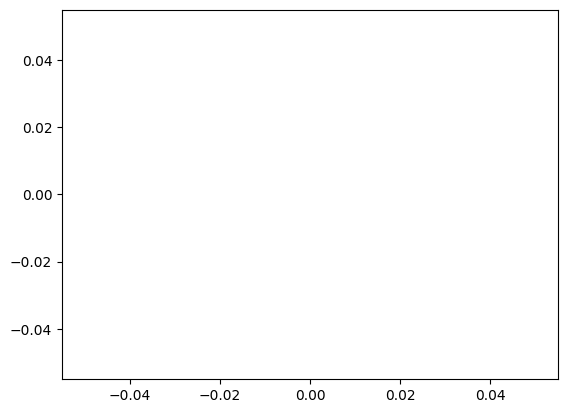

In [51]:
import matplotlib.pyplot as plt
plt.plot(train_losses)

In [22]:
from sklearn.metrics import f1_score
import numpy as np
def print_eval(y_pred):
    micro_f1 = f1_score(test_data.y, y_pred, average='micro')
    ratio_corr_labels = np.equal(test_data.y, y_pred).sum() / test_data.y.numel()
    print(f"F1-micro {str(micro_f1)} - Overall-Acc: {str(ratio_corr_labels)}")

In [23]:
evaluate(model, X_train, y_train)

tensor(0.5436, device='cuda:0')


In [25]:
with torch.inference_mode():
    model.eval()
    y_pred = torch.round(torch.sigmoid(model(X_test))).detach().cpu()
    print_eval(y_pred)

F1-micro 0.4263748920241866 - Overall-Acc: tensor(0.7467)
